# Skill predが高すぎるように感じる件についてのチケット


In [4]:
import torch
# if __name__ == '__main__':
#     # https://pytorch.org/tutorials/beginner/aws_distributed_training_tutorial.html#imports
#     torch.multiprocessing.set_start_method('spawn')
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split

import os
import sys
import time
import datetime
import logging
import random
import pickle
from pathlib import Path
import math
from math import log, ceil
from typing import List, Tuple, Set, Dict
from collections import defaultdict

import click
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from src.data import QandAEmbedder, slice_d
from basedkt import BaseDKT

In [6]:
print('PyTorch:', torch.__version__)
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev = torch.device('cpu')
print('Using Device:', dev)
model_name = 'baselstm'
# Parameters
n_skills = 326
batch_size, n_hidden, n_skills, n_layers = 100, 200, n_skills, 2
batch_size = 1
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = 2 * n_skills + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))

INPUT_DIM, ENC_EMB_DIM, ENC_DROPOUT = onehot_size, n_input, 0.6
OUTPUT_DIM, DEC_EMB_DIM, DEC_DROPOUT = onehot_size, n_input, 0.6
HID_DIM, N_LAYERS = n_hidden, n_layers
N_SKILLS = n_skills
# OUTPUT_DIM = n_output = 124  # TODO: ほんとはこれやりたい


def get_model():
    model = BaseDKT(
        dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size
    )
    checkpoint_path = '/home/adaptive-model-api/adaptive-model-api/models/201908010039_baselstm_0.6272209630147144.160'
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'), strict=False)
    model.eval()
    return model

model = get_model()


def predict_ks_from_history(history):
    # Transform to -> [(q1,a1),..]
    input = list()
    with open('/home/adaptive-model-api/adaptive-model-api/data/Asteria_Eng_ver5.1_dic.pickle', 'rb') as f:
        problems_dic = pickle.load(f)
    for h in history:
        ans = h['answer_result']
        sid = h['lo_id']
        sid_i = problems_dic[sid]
        input.append(
            (sid_i, ans)
        )

    # 
    M = 326
    sequence_size = 20
    qa_emb = QandAEmbedder(M, sequence_size)    

    xy_seq = slice_d(input, x_seq_size=sequence_size, type='base', sliding_window=0, reverse=True)[0] # most recent
    # TODO: inputが短いと、list index out of rangeになる
    sid_oh = qa_emb.sequenceToOnehot(xy_seq[1:])
    x_tensor = torch.Tensor([sid_oh])#.to(dev)
#     print(x_tensor.shape) #=> [21,654]

    # ################
#     print(model)
    # ################

    # ################
    input = x_tensor
    compressed_sensing = True
    if compressed_sensing and onehot_size != n_input:
        SEED = 0
        torch.manual_seed(SEED)
        cs_basis = torch.randn(onehot_size, n_input).to(dev)
        input = torch.mm(
            input.contiguous().view(-1, onehot_size), cs_basis)
        # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
        # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
        input = input.view(batch_size, sequence_size, n_input)
    input = input.permute(1, 0, 2)

    out = model(input)
    pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
    predicted_ks = pred
    # predicted_ks.shape => [1,326]
    ks = predicted_ks.detach().numpy()[0]
#     print(ks)
    # RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
    # model.eval()しても上のようなエラーが出た。どうしてだろう。
    # ################

    problems_dic_invert = {v:k for k,v in problems_dic.items()}
    result = dict()
    for i in range(predicted_ks.shape[1]):
        result[problems_dic_invert[i]] = float(ks[i])
    return result

PyTorch: 1.1.0
Using Device: cpu


## HistoryData

In [7]:
data = {"history": [
{"contents_id":"NEL03L01A071","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A141","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A021","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A091","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A181","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A161","lo_id":"NEL03L01","answer_result":0},
{"contents_id":"NEL03L01A011","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A061","lo_id":"NEL03L01","answer_result":0},
{"contents_id":"NEL01L02A091","lo_id":"NEL01L02","answer_result":1},
{"contents_id":"NEL02L03A061","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL01L02A011","lo_id":"NEL01L02","answer_result":1},
{"contents_id":"NEL02L01A131","lo_id":"NEL02L01","answer_result":1},
{"contents_id":"NEL03L01A121","lo_id":"NEL03L01","answer_result":0},
{"contents_id":"NEL02L03A151","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L01A181","lo_id":"NEL02L01","answer_result":1},
{"contents_id":"NEL02L03A111","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL03L01A131","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A051","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A031","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A041","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A171","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A101","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A111","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L01A081","lo_id":"NEL03L01","answer_result":1},
{"contents_id":"NEL03L02A011","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A071","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A041","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A151","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A031","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A021","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A181","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A171","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A051","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL02L03A081","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL03L02A081","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A091","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A111","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A131","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL02L03A131","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL03L02A141","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A061","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A201","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A191","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A161","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A101","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A121","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL02L03A031","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A011","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A091","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A051","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A021","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A101","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A071","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A121","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A041","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A141","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL03L02A051","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A141","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A011","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A081","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A131","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A181","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A061","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A041","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A101","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A191","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL02L03A061","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A031","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A011","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A051","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A151","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A121","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL03L02A091","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A171","lo_id":"NEL03L02","answer_result":0},
{"contents_id":"NEL03L02A031","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A111","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A021","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A121","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A201","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A071","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A151","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A161","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A181","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A051","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A041","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L02A191","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL02L03A131","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A091","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A081","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A101","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A021","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A141","lo_id":"NEL02L03","answer_result":0},
{"contents_id":"NEL02L03A111","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A071","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL02L03A041","lo_id":"NEL02L03","answer_result":1},
{"contents_id":"NEL03L02A131","lo_id":"NEL03L02","answer_result":1},
{"contents_id":"NEL03L03A041","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL01L06A031","lo_id":"NEL01L06","answer_result":1},
{"contents_id":"NEL01L06A041","lo_id":"NEL01L06","answer_result":1},
{"contents_id":"NEL03L03A091","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A051","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL01L07A071","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A041","lo_id":"NEL01L07","answer_result":0},
{"contents_id":"NEL03L03A081","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A011","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A141","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A031","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A061","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A111","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A131","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A121","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A151","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A101","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A071","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A021","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL01L07A121","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A051","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A011","lo_id":"NEL01L07","answer_result":0},
{"contents_id":"NEL01L07A101","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A081","lo_id":"NEL01L07","answer_result":0},
{"contents_id":"NEL01L07A141","lo_id":"NEL01L07","answer_result":0},
{"contents_id":"NEL01L07A111","lo_id":"NEL01L07","answer_result":0},
{"contents_id":"NEL01L07A131","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A061","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A151","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A021","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A031","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL01L07A091","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL03L03A151","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A131","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A111","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A071","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A041","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A011","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A051","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A121","lo_id":"NEL03L03","answer_result":0},
{"contents_id":"NEL03L03A101","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A031","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A061","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A141","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A081","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A091","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A131","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A021","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A041","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL01L07A011","lo_id":"NEL01L07","answer_result":1},
{"contents_id":"NEL03L03A071","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L03A121","lo_id":"NEL03L03","answer_result":1},
{"contents_id":"NEL03L04A191","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL02L04A131","lo_id":"NEL02L04","answer_result":1},
{"contents_id":"NEL03L04A141","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A151","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A181","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A111","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A031","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A071","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A161","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A061","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A081","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A091","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A051","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A201","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A121","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A041","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A101","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A171","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A011","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A131","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A021","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A181","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A151","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A031","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A191","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A081","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A051","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A041","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A171","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A071","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A141","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A201","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A121","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A091","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A101","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A011","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A131","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A061","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A111","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A161","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A021","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A081","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A151","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A041","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A031","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A051","lo_id":"NEL03L04","answer_result":0},
{"contents_id":"NEL03L04A181","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A201","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A121","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A191","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NEL03L04A101","lo_id":"NEL03L04","answer_result":1},
{"contents_id":"NER03L01A011","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A021","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A081","lo_id":"NER03L01","answer_result":0},
{"contents_id":"NER01L03A151","lo_id":"NER01L03","answer_result":0},
{"contents_id":"NER01LA2A091","lo_id":"NER01LA2","answer_result":1},
{"contents_id":"NER01L01A031","lo_id":"NER01L01","answer_result":0},
{"contents_id":"NER01LA2A071","lo_id":"NER01LA2","answer_result":1},
{"contents_id":"NER01L01A101","lo_id":"NER01L01","answer_result":0},
{"contents_id":"NER01LA2A061","lo_id":"NER01LA2","answer_result":1},
{"contents_id":"NER01LA2A011","lo_id":"NER01LA2","answer_result":1},
{"contents_id":"NER01L01A071","lo_id":"NER01L01","answer_result":1},
{"contents_id":"NER01L01A151","lo_id":"NER01L01","answer_result":1},
{"contents_id":"NER01L01A041","lo_id":"NER01L01","answer_result":1},
{"contents_id":"NER01L01A091","lo_id":"NER01L01","answer_result":1},
{"contents_id":"NER01L01A051","lo_id":"NER01L01","answer_result":1},
{"contents_id":"NER03L01A111","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A051","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A041","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A061","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A121","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A141","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER03L01A101","lo_id":"NER03L01","answer_result":1},
{"contents_id":"NER02L01A131","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER03L02A131","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A151","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A011","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A071","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A081","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER03L02A041","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A091","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER03L02A051","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A121","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER02L01A011","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER03L02A061","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A021","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER01L04A131","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER02L01A081","lo_id":"NER02L01","answer_result":0},
{"contents_id":"NER02L01A091","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER03L02A031","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER02L01A151","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER01L04A011","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER02L01A031","lo_id":"NER02L01","answer_result":0},
{"contents_id":"NER02L01A051","lo_id":"NER02L01","answer_result":0},
{"contents_id":"NER02L01A121","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER02L01A021","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER02L01A141","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER01L04A091","lo_id":"NER01L04","answer_result":0},
{"contents_id":"NER02L01A061","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER02L01A041","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER02L01A111","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER03L02A141","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A101","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER02L01A101","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER01L04A081","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER03L02A111","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER02L01A071","lo_id":"NER02L01","answer_result":1},
{"contents_id":"NER01L04A031","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A021","lo_id":"NER01L04","answer_result":0},
{"contents_id":"NER01L04A061","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A141","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A071","lo_id":"NER01L04","answer_result":0},
{"contents_id":"NER01L04A111","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A041","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A151","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A051","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A121","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER01L04A101","lo_id":"NER01L04","answer_result":1},
{"contents_id":"NER03L02A021","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A081","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A121","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A031","lo_id":"NER03L02","answer_result":0},
{"contents_id":"NER03L02A091","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A101","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A151","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A131","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A051","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A061","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A011","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L02A071","lo_id":"NER03L02","answer_result":1},
{"contents_id":"NER03L03A101","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A121","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L03A141","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L02A071","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A061","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A111","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A081","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L03A091","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L02A091","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A031","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A131","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A021","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A151","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A041","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A051","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A101","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A011","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A121","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L03A101","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L02A141","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L03A031","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A131","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER01L02A131","lo_id":"NER01L02","answer_result":1},
{"contents_id":"NER02L03A111","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A021","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A041","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A151","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A061","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A081","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A081","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L03A121","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A051","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A011","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A071","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A111","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER01L02A061","lo_id":"NER01L02","answer_result":1},
{"contents_id":"NER03L03A071","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A141","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A031","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A041","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A051","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A151","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A021","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A011","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A091","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A131","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A061","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L02A061","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A041","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A151","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A091","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A031","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A101","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER01L03A071","lo_id":"NER01L03","answer_result":1},
{"contents_id":"NER01L03A041","lo_id":"NER01L03","answer_result":1},
{"contents_id":"NER02L03A091","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A141","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A101","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A011","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A041","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L03A041","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A021","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A061","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A121","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A151","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A081","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A071","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L03A151","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A021","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A121","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A111","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A051","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A051","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A091","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER03L03A111","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A031","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A011","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A101","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A131","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A141","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER02L02A071","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A021","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A111","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A081","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A051","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER03L03A041","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A081","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A121","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A071","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER02L02A131","lo_id":"NER02L02","answer_result":0},
{"contents_id":"NER02L02A121","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A141","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L02A011","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER02L03A081","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A071","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L03A061","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A131","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A031","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER03L03A091","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A061","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A151","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A021","lo_id":"NER03L03","answer_result":0},
{"contents_id":"NER02L03A111","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A151","lo_id":"NER02L03","answer_result":1},
{"contents_id":"NER02L03A141","lo_id":"NER02L03","answer_result":0},
{"contents_id":"NER02L02A041","lo_id":"NER02L02","answer_result":1},
{"contents_id":"NER03L03A101","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A011","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A131","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L03A031","lo_id":"NER03L03","answer_result":1},
{"contents_id":"NER03L04A041","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A081","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A121","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A141","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A111","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A091","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A101","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A151","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A021","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A051","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A061","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A031","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A071","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A131","lo_id":"NER03L04","answer_result":0},
{"contents_id":"NER03L04A011","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A141","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A041","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A121","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A151","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A021","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A061","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A031","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A071","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A131","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A011","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A101","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A091","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A081","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A051","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NER03L04A111","lo_id":"NER03L04","answer_result":1},
{"contents_id":"NEW04L01A171","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A241","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A051","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A151","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A111","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A121","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A211","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A081","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A141","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A061","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A191","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A271","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A071","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A131","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A231","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A181","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A261","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A041","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A161","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A221","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A201","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A091","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A101","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A281","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A031","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A021","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A011","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A061","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A271","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A111","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A051","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A071","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A211","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A081","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A261","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A221","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A131","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A091","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A101","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A281","lo_id":"NEW04L01","answer_result":0},
{"contents_id":"NEW04L01A031","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A241","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A231","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A041","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A181","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A161","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A121","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A171","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A201","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A191","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A151","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A141","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A011","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A021","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L01A221","lo_id":"NEW04L01","answer_result":1},
{"contents_id":"NEW04L02A111","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A021","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A101","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A031","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A161","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A171","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A011","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A141","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A151","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A121","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A071","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A061","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A081","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A041","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A101","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A111","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A161","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A031","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A121","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A071","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A061","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A041","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A081","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A141","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A151","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A021","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A171","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A011","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A121","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A111","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A101","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A031","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A161","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A071","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A041","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A081","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A061","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A101","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A031","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A141","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A151","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A021","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A171","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A011","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A121","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A111","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A161","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A041","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A081","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A061","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A071","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A141","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A101","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A111","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A031","lo_id":"NEW04L02","answer_result":0},
{"contents_id":"NEW04L02A151","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A021","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04L02A171","lo_id":"NEW04L02","answer_result":1},
{"contents_id":"NEW04M01A451","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A271","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A471","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A291","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A461","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A281","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A271","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A291","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A461","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A451","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A281","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A471","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A291","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A281","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A461","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A451","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A471","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A271","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A281","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A461","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A291","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A471","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A451","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A271","lo_id":"NEW04M01","answer_result":0},
{"contents_id":"NEW04M01A281","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A291","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04M01A471","lo_id":"NEW04M01","answer_result":1},
{"contents_id":"NEW04L03A211","lo_id":"NEW04L03","answer_result":1},
{"contents_id":"NES03L01A091","lo_id":"NES03L01","answer_result":0},
{"contents_id":"NES03M01A061","lo_id":"NES03M01","answer_result":0},
{"contents_id":"NES02L04A081","lo_id":"NES02L04","answer_result":0},
{"contents_id":"NES03M01A021","lo_id":"NES03M01","answer_result":1},
{"contents_id":"NES02M02A061","lo_id":"NES02M02","answer_result":0},
{"contents_id":"NES02L03A101","lo_id":"NES02L03","answer_result":1},
{"contents_id":"NES03L01A021","lo_id":"NES03L01","answer_result":1},
{"contents_id":"NES03L01A131","lo_id":"NES03L01","answer_result":1},
{"contents_id":"NES03L01A041","lo_id":"NES03L01","answer_result":0},
{"contents_id":"NES02L04A111","lo_id":"NES02L04","answer_result":0},
{"contents_id":"NES02L03A081","lo_id":"NES02L03","answer_result":0},
{"contents_id":"NES01L04A131","lo_id":"NES01L04","answer_result":1},
{"contents_id":"NES03M01A121","lo_id":"NES03M01","answer_result":0},
{"contents_id":"NES02M02A011","lo_id":"NES02M02","answer_result":1},
{"contents_id":"NES03M01A031","lo_id":"NES03M01","answer_result":1},
{"contents_id":"NES03M01A041","lo_id":"NES03M01","answer_result":0},
{"contents_id":"NES03M01A111","lo_id":"NES03M01","answer_result":1},
{"contents_id":"NES03M01A051","lo_id":"NES03M01","answer_result":0},
{"contents_id":"NES03M01A071","lo_id":"NES03M01","answer_result":1},
{"contents_id":"NES03M01A011","lo_id":"NES03M01","answer_result":1},
]}


## Calculate sum

In [72]:
mode = 'moving'
history = data['history']
lo_involved = set([h['lo_id'] for h in history])
lo_actu = {lo:[0,0] for lo in lo_involved}
lo_line_graph_a = defaultdict(list)
lo_line_graph_p = defaultdict(list)

for h in history[:21]:
    lo_actu[h['lo_id']][h['answer_result']] += 1
print(lo_actu)
for i in range(len(history)-21):
    h = history[i:i+21]
    lo_actu[h[-1]['lo_id']][h[-1]['answer_result']] += 1
    result = predict_ks_from_history(h)
    
    for k, v in lo_actu.items():
        percent = 0 if sum(v) == 0 else (v[1] / sum(v))
        lo_line_graph_a[k].append(percent)
    for lo in lo_involved:
        lo_line_graph_p[lo].append(result[lo])
# print(lo_line_graph)

if mode == 'moving':
    for k, v in lo_actu.items():
        values = np.array(lo_line_graph_a[k])
        values = values[np.nonzero(values)]
        if len(values) == 0:
            continue
        num = 10 if len(values) > 10 else len(values)
        b = np.ones(num)/float(num)
        lo_line_graph_a[k] = np.convolve(lo_line_graph_a[k], b, 'same').tolist()

{'NER02L02': [0, 0], 'NEL02L03': [2, 1], 'NES01L04': [0, 0], 'NER01L03': [0, 0], 'NEW04M01': [0, 0], 'NES03L01': [0, 0], 'NEL01L02': [0, 2], 'NER02L03': [0, 0], 'NER01L02': [0, 0], 'NES02M02': [0, 0], 'NEL03L01': [3, 11], 'NEW04L03': [0, 0], 'NEL03L02': [0, 0], 'NER01L04': [0, 0], 'NES03M01': [0, 0], 'NEL02L04': [0, 0], 'NEW04L02': [0, 0], 'NER03L04': [0, 0], 'NEL02L01': [0, 2], 'NEL01L07': [0, 0], 'NER03L03': [0, 0], 'NER01LA2': [0, 0], 'NEL03L03': [0, 0], 'NEW04L01': [0, 0], 'NEL03L04': [0, 0], 'NER03L01': [0, 0], 'NER02L01': [0, 0], 'NES02L03': [0, 0], 'NER01L01': [0, 0], 'NER03L02': [0, 0], 'NEL01L06': [0, 0], 'NES02L04': [0, 0]}


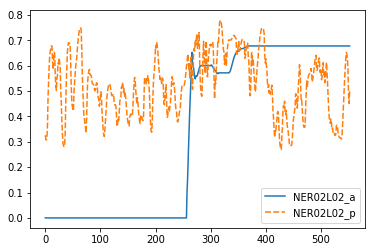

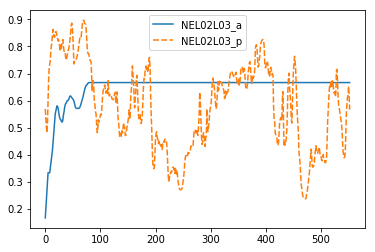

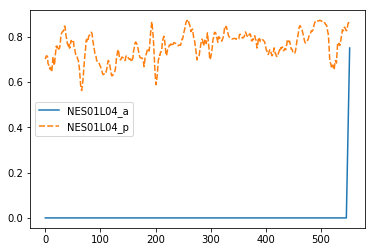

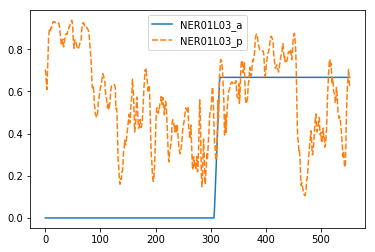

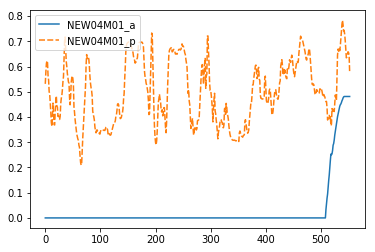

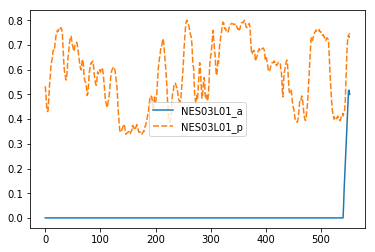

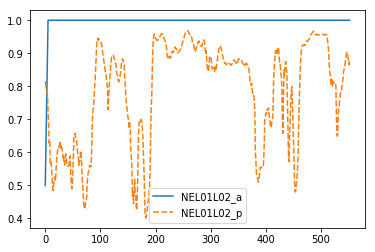

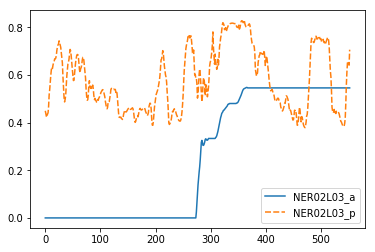

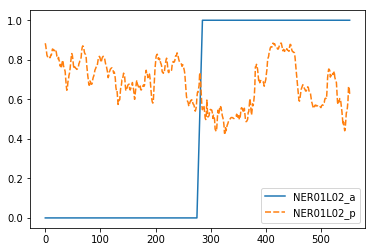

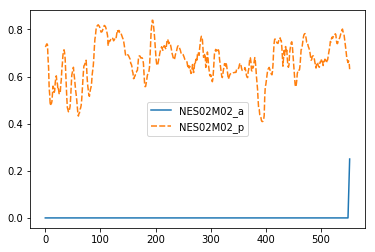

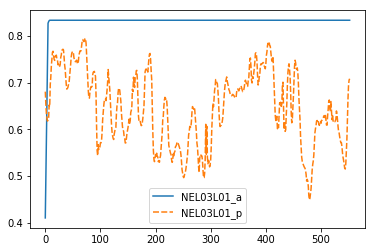

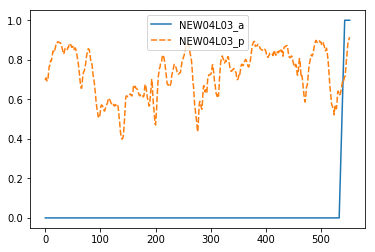

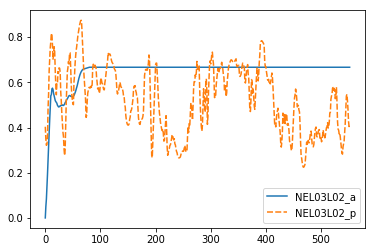

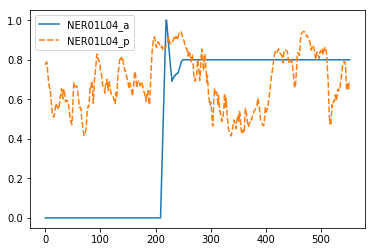

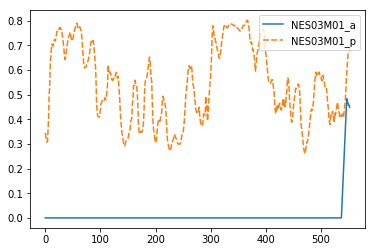

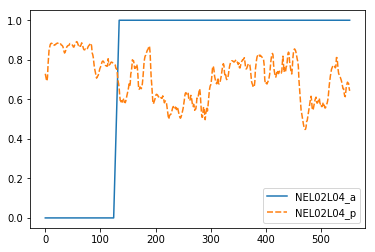

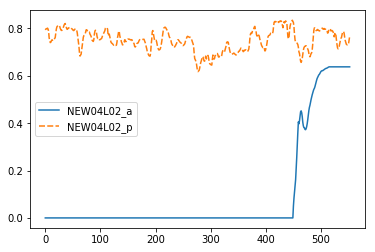

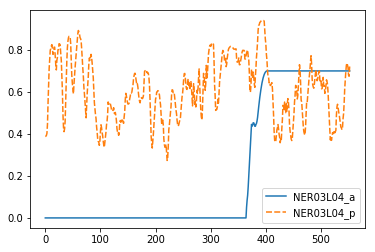

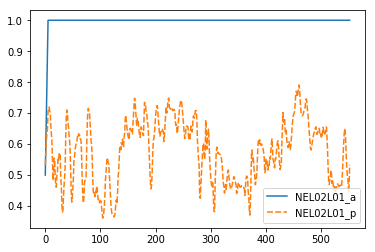

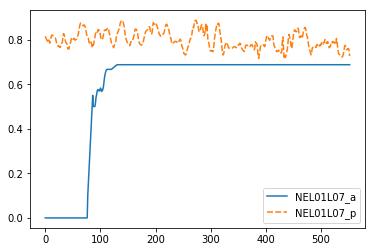

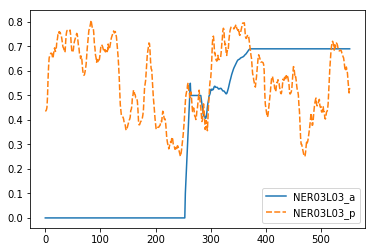

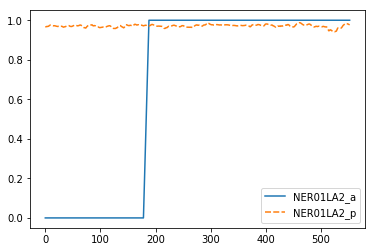

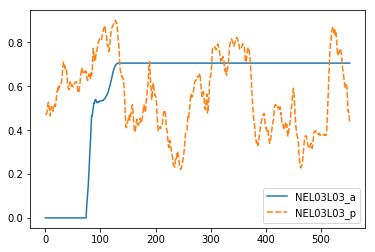

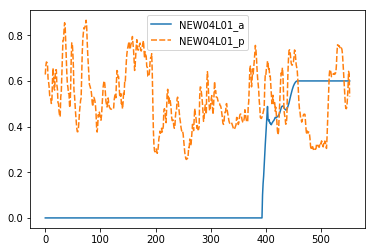

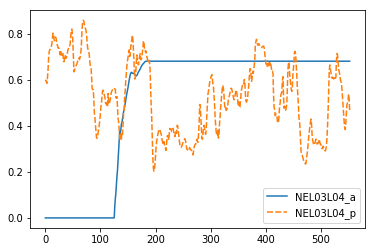

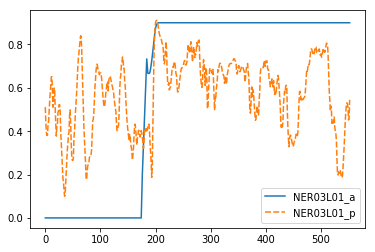

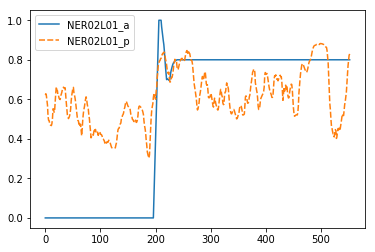

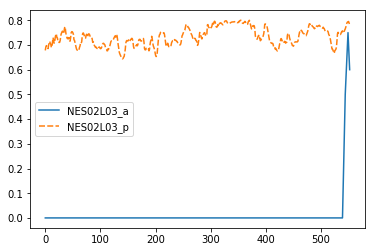

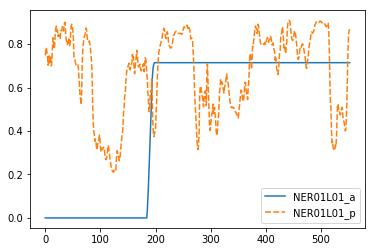

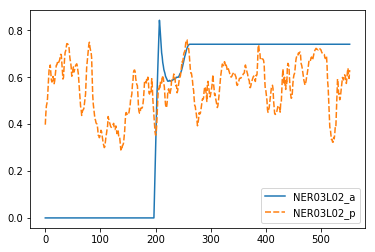

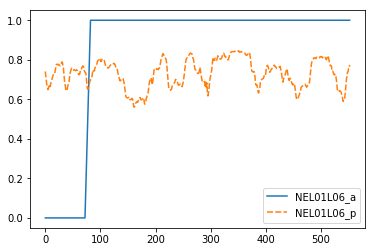

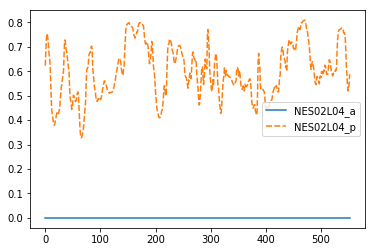

In [74]:
def preliminary_tremor_index(data):
    for i, d in enumerate(data):
        if d > 0:
            return i
    return 0

for lo in lo_involved:
    sns.lineplot(data=pd.DataFrame({lo+'_a': lo_line_graph_a[lo][:-5],
                                    lo+'_p': lo_line_graph_p[lo][:-5]}))
#     index = preliminary_tremor_index(lo_line_graph_a[lo])
#     plt.xlim(index,index+30)
    plt.show()